# Medical Data Science Assignment

**University of Tübingen**  
*Course: Medical Data Science*  
*Instructors: Nico Pfeifer*  

**Authors:**  
- Oğuz Ata Çal (Student Number: 6661014)  
- Edward Beach (Student Number: 5451904)

**Date:** [06.12.2023]  
**Assignment:** [Assignment 4]

---

This is the jupiter notebook for the problem 2 of the Assignment 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from grakel.kernels import WeisfeilerLehman, GraphletSampling, edge_histogram
from grakel.datasets import fetch_dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tqdm as tqdm

Node labels: 0  C, 1  N, 2  O, 3  F, 4  I, 5  Cl, 6  Br

Edge labels: 0  aromatic, 1  single, 2  double, 3  triple

In [2]:
MUTAG = fetch_dataset("MUTAG", verbose=True, data_home="C:/Users/excal/Desktop/Github/MDS_Tubingen/HW_4")
G = MUTAG.data
y = MUTAG.target

Extracting dataset  MUTAG..
Parsing dataset  MUTAG..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..


In [3]:
y.shape, len(G)

((188,), 188)

In [4]:
# global dictionary for test results
test_results = {}
def train_svm_with_cross_validation(x_train, y_train, c_values=[0.0001, 0.001, 0.01, 0.1, 1, 10], num_folds=10):
    """
    Train an SVM with precomputed kernel matrices using 10-fold cross-validation.

    Parameters:
    - x_train: Precomputed kernel matrix for training data
    - y_train: Labels for training data
    - x_test: Precomputed kernel matrix for testing data
    - y_test: Labels for testing data
    - c_values: List of C values to be tested
    - num_folds: Number of folds for cross-validation

    Returns:
    - best_c: The best C value based on cross-validation
    - best_accuracy: Accuracy corresponding to the best C value
    - best_model: Trained SVM model with the best C value
    - mean_accuracies: Dictionary of mean accuracies for each C value
    """
    # Initialize variables to store the best C and its corresponding accuracy
    best_c = None
    best_accuracy = 0.0
    best_model = None
    mean_accuracies = {}

    # Perform cross-validation for each C value
    for c in tqdm.tqdm(np.array(c_values)):
        # Create an SVM model with a precomputed kernel
        svm_model = svm.SVC(C=c, kernel='precomputed')
        
        # Perform 10-fold cross-validation
        cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
        accuracies = cross_val_score(svm_model, x_train, y_train, cv=cv, scoring='accuracy')

        # Calculate the mean accuracy across folds
        mean_accuracy = np.mean(accuracies)

        mean_accuracies[c] = mean_accuracy

        # Update the best C, accuracy, and model if a higher accuracy is found
        if mean_accuracy > best_accuracy:
            best_c = c
            best_accuracy = mean_accuracy
            best_model = svm_model.fit(x_train, y_train)

    # Return the best C value, its corresponding accuracy, and the trained model
    return best_c, best_accuracy, best_model, mean_accuracies

def test_svm(model, x_test, y_test):
    """
    Test an SVM with precomputed kernel matrices.

    Parameters:
    - model: Trained SVM model
    - x_test: Precomputed kernel matrix for testing data
    - y_test: Labels for testing data

    Returns:
    - accuracy: Accuracy of the model on the test data
    """
    # Make predictions on the test data
    y_pred = model.predict(x_test)

    # Calculate the accuracy of the model on the test data
    accuracy = accuracy_score(y_test, y_pred)
    
    # Return the accuracy
    return accuracy

## Graphlet kernel

In [14]:
graphletKernel = GraphletSampling(normalize=True, sampling={"n_samples": 1000, "sampling": "uniform"}, k=3)

In [15]:
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.2, random_state=42)

graphletKernel.fit(G_train)

K_train = graphletKernel.transform(G_train)
K_test = graphletKernel.transform(G_test)

In [16]:
best_c, best_accuracy, best_model, mean_accuracies = train_svm_with_cross_validation(K_train, y_train)

print("Best C:", best_c)
print("Best accuracy:", best_accuracy)
print("Mean accuracies:", mean_accuracies)

accuracy = test_svm(best_model, K_test, y_test)
print("Test accuracy:", accuracy)

test_results['Graphlet Sampling'] = [accuracy, best_c]

100%|██████████| 6/6 [00:00<00:00, 25.39it/s]

Best C: 1.0
Best accuracy: 0.7933333333333333
Mean accuracies: {0.0001: 0.6599999999999999, 0.001: 0.6599999999999999, 0.01: 0.6599999999999999, 0.1: 0.6599999999999999, 1.0: 0.7933333333333333, 10.0: 0.7866666666666666}
Test accuracy: 0.8421052631578947


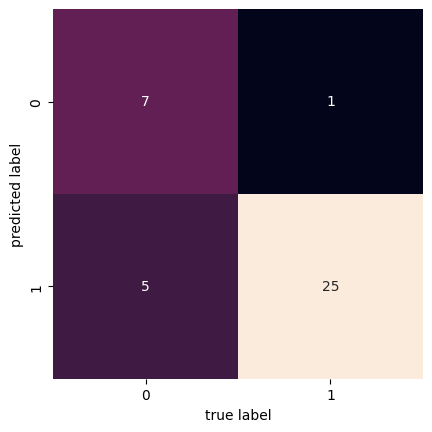

In [17]:
# show confusion matrix
y_pred = best_model.predict(K_test)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

How many samples would you need such that the deviation from the real distribution is less than 0.05 with probability larger than 0.9?

In [29]:
# find the largest graph in the dataset
max_size = 0
for g in G:
    if len(g[1]) > max_size:
        max_size = len(g[1])
print(f"Largest graph has size: {max_size}")

def calculate_m(len_of_largest_graph, e, delta):
    # calculate the number of graphlets of size 3
    a = int(len_of_largest_graph * (len_of_largest_graph - 1) * (len_of_largest_graph - 2) / 6)

    # print the size of the set of all size k graphlets
    print(f"Size of set of all size k graphlets: {a}")
    return int(np.ceil(2*(np.log(2)*a + np.log(1/delta)) / (e**2)))

# calculate the number of samples you need such that the error is less than 0.05 with probability larger than 0.9
m = calculate_m(max_size, 0.05, 0.1)
print(f"Number of samples needed such that the error is less than 0.05 with probability larger than 0.9: {m}")


Largest graph has size: 28
Size of set of all size k graphlets: 3276
Number of samples needed such that the error is less than 0.05 with probability larger than 0.9: 1818443


## Weisfeiler-Lehman subtree kernel

In [9]:
gk = WeisfeilerLehman(n_iter=4, normalize=True)

In [10]:
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.2, random_state=42)

gk.fit(G_train)
K_train = gk.transform(G_train)
K_test = gk.transform(G_test)

In [11]:
best_c, best_accuracy, best_model, mean_accuricies = train_svm_with_cross_validation(K_train, y_train)
print(f"Best C: {best_c}, Best Training Accuracy: {best_accuracy}")
print(mean_accuricies)

test_accuracy = test_svm(best_model, K_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

test_results['WeisfeilerLehman'] = [test_accuracy, best_c]

100%|██████████| 6/6 [00:00<00:00, 35.41it/s]

Best C: 10.0, Best Training Accuracy: 0.8266666666666668
{0.0001: 0.6599999999999999, 0.001: 0.6599999999999999, 0.01: 0.6599999999999999, 0.1: 0.6599999999999999, 1.0: 0.7333333333333334, 10.0: 0.8266666666666668}
Test Accuracy: 0.9473684210526315


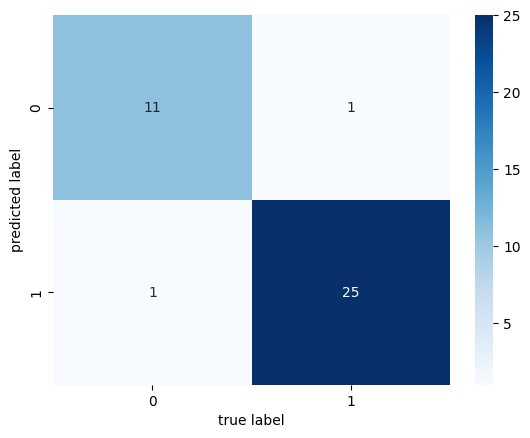

In [12]:
# show the confusion matrix
y_pred = best_model.predict(K_test)
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [13]:
# find the largest graph in the dataset
max_size = 0
for i in range(len(G)):
    if len(G[i]) > max_size:
        max_size = len(G[i])

def calculate_m(len_of_largest_graph, e, delta):
    # calculate the number of graphlets of size 3
    a = int(len_of_largest_graph * (len_of_largest_graph - 1) * (len_of_largest_graph - 2) / 6)

    # print the size of the set of all size k graphlets
    print(f"Size of set of all size k graphlets: {a}")
    return int(np.ceil(2(np.log(2)*a + np.log(1/delta)) / (e**2)))

# calculate the number of samples you need such that the error is less than 0.05 with probability larger than 0.9
m = calculate_m(max_size, 0.05, 0.1)


<>:13: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:13: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
C:\Users\excal\AppData\Local\Temp\ipykernel_7796\3058448146.py:13: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  return int(np.ceil(2(np.log(2)*len(a) + np.log(1/delta)) / (e**2)))


TypeError: object of type 'float' has no len()

## Weisfeiler-Lehman edge kernel

In [ ]:
gk = WeisfeilerLehman(n_iter=1, normalize=True, base_graph_kernel=edge_histogram.EdgeHistogram)

In [ ]:
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.2, random_state=42)

gk.fit(G_train)
K_train = gk.transform(G_train)
K_test = gk.transform(G_test)

In [ ]:
best_c, best_accuracy, best_model, mean_accuricies = train_svm_with_cross_validation(K_train, y_train, c_values=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100])

print(f"Best C: {best_c}, Best Training Accuracy: {best_accuracy}")
print(mean_accuricies)

test_accuracy = test_svm(best_model, K_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

test_results['Weisfeiler-Lehman edge kernel'] = [test_accuracy, best_c]

100%|██████████| 7/7 [00:00<00:00, 36.94it/s]

Best C: 1.0, Best Training Accuracy: 0.6933333333333334
{0.0001: 0.6599999999999999, 0.001: 0.6599999999999999, 0.01: 0.6599999999999999, 0.1: 0.6599999999999999, 1.0: 0.6933333333333334, 10.0: 0.6933333333333334, 100.0: 0.6933333333333334}
Test Accuracy: 0.7105263157894737


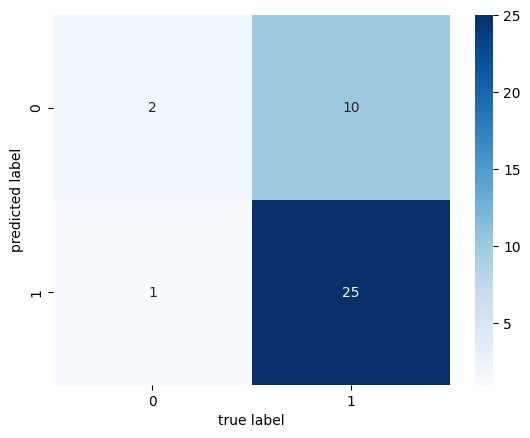

In [ ]:
# show the confusion matrix
y_pred = best_model.predict(K_test)
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

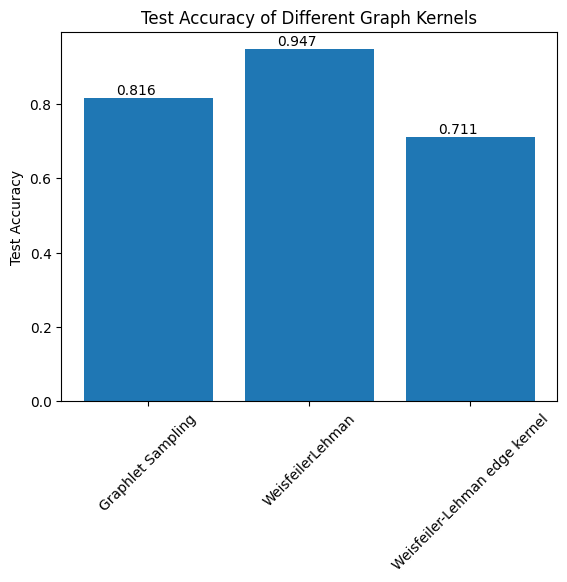

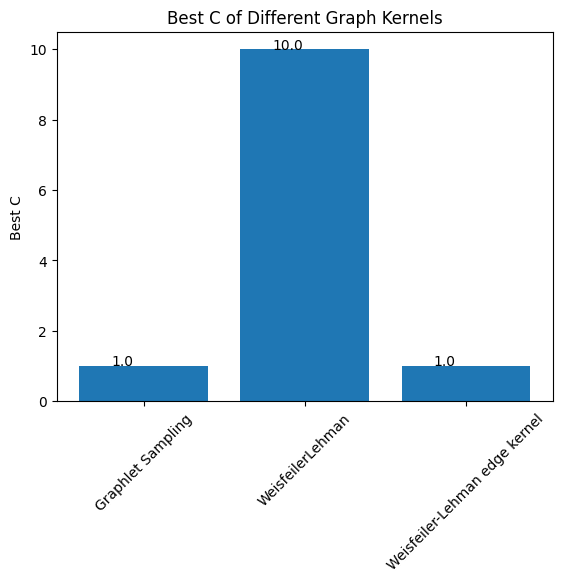

In [ ]:
# plot the results and label the individual bars
plt.bar(range(len(test_results)), [x[0] for x in test_results.values()], align='center')
plt.xticks(range(len(test_results)), list(test_results.keys()), rotation=45)
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of Different Graph Kernels')
for i, v in enumerate(test_results.values()):
    plt.text(i-0.2, v[0]+0.01, str(round(v[0], 3)))
plt.show()

# plot the results and label the individual bars
plt.bar(range(len(test_results)), [x[1] for x in test_results.values()], align='center')
plt.xticks(range(len(test_results)), list(test_results.keys()), rotation=45)
plt.ylabel('Best C')
plt.title('Best C of Different Graph Kernels')
for i, v in enumerate(test_results.values()):
    plt.text(i-0.2, v[1]+0.01, str(round(v[1], 3)))
plt.show()
